# This file shows the process of creating an EA using ARIEL 

### How does ARIEL EC module work?

The ARIEL EC (Evolutionary Computing) module works a bit different than other EAs (Evolutionary Algorithms). While other EAs represent the population as a simple list of individuals, here they the population is made as its own class, with a population being type of `list[Individuals]`. 

Similarly, in traditional EA architecture an individual is chosen for certain operators (for example parent selection) according to some criteria, put into a separate list and then given to the operator function. ARIEL works by giving individuals what we call `tags`. An individual has `tags` that can be toggled, which qualify it for any and all operations. The tag can be whether an individual can crossover or mutate in the future, but it can also show if it can enter the learning cycle.

The tags can be changed at all times, and default values for each tag can be given to more closely represent a traditional EA structure.

Additionally, ARIEL utilizes an SQL database to handle the variables and outputs of the code. This makes the code run faster, but it adds an extra step to the process.

This file demonstrates the process of initializing an EA class and running it for a simple problem, in our case, the Ackley function.

In [ ]:
# Standard library
import random
from collections.abc import Callable
from dataclasses import dataclass
from pathlib import Path
from typing import Literal, cast

# Pretty little errors and progress bars
from rich.console import Console
from rich.progress import track
from rich.traceback import install

# Third-party libraries
import numpy as np
from pydantic_settings import BaseSettings
from sqlalchemy import create_engine
from sqlmodel import Session, SQLModel, col, select

# Local libraries
from ariel.ec.a000 import IntegerMutator, IntegersGenerator
from ariel.ec.a001 import Individual
from ariel.ec.a005 import Crossover

# Library to show fitness landscape
import matplotlib.pyplot as plt
from .fitness_plot import fitness_landscape_plot

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:26                                                                                   │
│                                                                                                  │
│   23                                                                                             │
│   24 # Library to show fitness landscape                                                         │
│   25 import matplotlib.pyplot as plt                                                             │
│ ❱ 26 from fitness_plot import fitness_landscape_plot                                             │
│   27                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'fitness_plot'

#### Define the fitness function

In [13]:
def Ackley(x):
    """source: https://www.sfu.ca/~ssurjano/ackley.html"""

    # Ackley function parameters
    a = 20
    b = 0.2
    c = 2 * np.pi
    dimension = len(x)

    # Individual terms
    term1 = -a * np.exp(-b * np.sqrt(sum(x**2) / dimension))
    term2 = -np.exp(sum(np.cos(c * xi) for xi in x) / dimension)
    return term1 + term2 + a + np.exp(1)

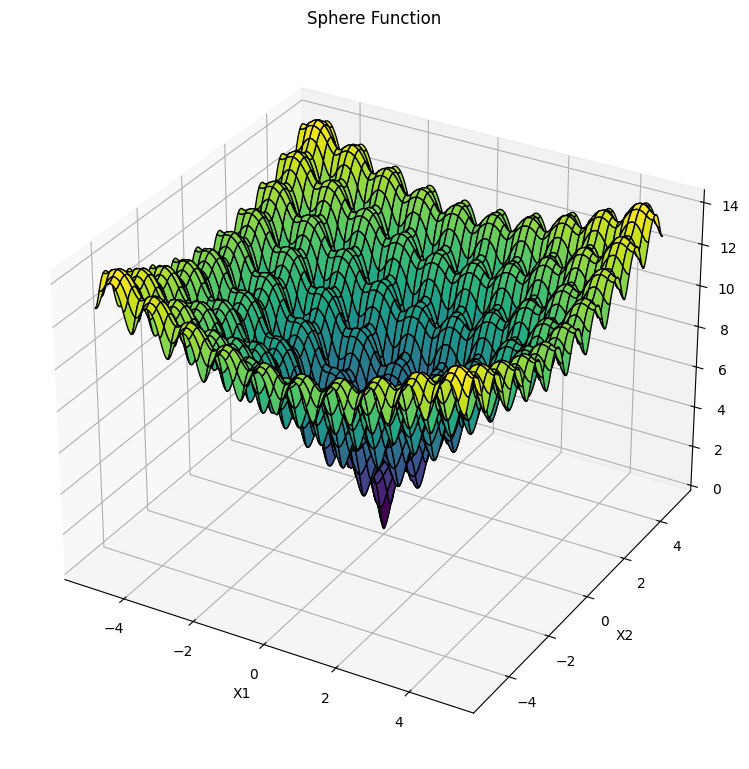

#### Initialize the global constants

In [ ]:
# A seed is optional, but it helps with reproducibility
SEED = 42

# The database has a few handling modes
    # "delete" will delete the existing database
    # "halt" will stop the execution if a database already exists
DB_HANDLING_MODES = Literal["delete", "halt"]

# Initialize RNG
RNG = np.random.default_rng(SEED)

# Initialize rich console and traceback handler
install()
console = Console()

In [3]:
# Type aliases to help with annotations
type Population = list[Individual]
type PopulationFunc = Callable[[Population], Population]

### After importing all necessary libraries we can start defining the base classes.

In [ ]:
# It is easier if you define a EAconfig class

class EAconfig(BaseSettings):

    # EC parameters
    is_maximization: bool = False
    first_gen_id: int = 0
    num_generations: int = 100
    target_population_size: int = 100

    # Data config
    output_path: Path = Path.cwd() / 'results'
    db_file_name: str = 'database_sphere.db'
    db_file_path: Path = output_path / db_file_name
    db_handling_mode: DB_HANDLING_MODES = "delete"

config = EAconfig()

# Lets see the parameters we just set
for conf in config:
    print(f"{conf[0]}: {conf[1]}")

maximizing: False
first_gen_id: 0
num_generations: 100
population_size: 100
output_path: d:\University\EC TA\ariel\examples\results
db_file_name: database_sphere.db
db_file_path: d:\University\EC TA\ariel\examples\results\database_sphere.db
db_handling_mode: delete


#### The next class we need to define is the  EA class, this allows us to implement many different EAs by reusing the base classes as well.

In [ ]:
# Initialize the database
class DBHandler:
    def init_database(self, 
                      db_file_path: Path | None=None, # for simplicity we'll assume this is already type Path 
                      db_handling: DB_HANDLING_MODES | None= None
                      ) -> None:
        
        # Print the handling mode so old data is not lost
        db_exists = db_file_path.exists()

        if db_exists and db_handling == "delete":
            console.log(f"Database {db_file_path} already exists, deleting it.")
            db_file_path.unlink()
            
        elif db_exists and db_handling == "halt":
            console.log(f"Database {db_file_path} already exists, halting execution.")
            raise FileExistsError(f"Database {db_file_path} already exists.")
        
        self.engine = create_engine(f"sqlite:///{db_file_path}")
        SQLModel.metadata.create_all(self.engine)


#### Here we define the Step dataclass. This allows us to later create the EA in a similar way to nn.Sequential.

In [ ]:
@dataclass
class EAStep:
    name: str
    func: PopulationFunc

    def __call__(self, population: Population) -> Population:
        return self.func(population)

#### We finally get to initialize the EA class

In [ ]:
class EA(DBHandler):
    def __init__(self, 
                 population: Population,
                 operations: list[EAStep],
                 num_generations: int | None = None,
                 *,
                 first_gen_id: int | None = None,
                 quiet: bool = False
                 ) -> None:
        super().__init__()
        # Local params
        self.population = population

        # Flexible params
        self.quiet = quiet
        self.console = Console(quiet=self.quiet)
        self.current_gen = first_gen_id or config.first_gen_id
        self.num_generations = num_generations or config.num_generations

        # Bound params
        self.is_maximization = config.is_maximization
        self.target_population_size = config.target_population_size

        # Initialize 
        self.init_database()
        self.population = population
        self.commit_population()
        self.console.rule("[blue]EA Initialized")

        @property
        def population_size(self) -> int:
            return len(self.population)
        
        def commit_population(self) -> None:
            with Session(self.engine) as session:
                for ind in self.population:
                    if ind.time_of_birth == -1:
                        ind.time_of_birth = self.current_gen
                session.commit()


# This notebook is work in progress